# Определение возраста покупателей

**Название проекта.**

Определение возраста покупателей по фотографиям для сети супермаркетов «Хлеб-Соль».

**Описание проекта.**

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для анализа фотографий покупателей в прикассовой зоне. Цель проекта — разработка модели машинного обучения, которая по фотографии сможет определять приблизительный возраст человека. Это позволит анализировать покупательские предпочтения по возрастным группам и контролировать соблюдение правил продажи алкоголя. В распоряжении имеется набор фотографий людей с указанием их возраста.

**Задачи проекта.**

1. Провести исследовательский анализ набора фотографий для выявления особенностей данных.
2. Обучить нейронную сеть для определения возраста по фотографиям.
3. Оценить качество модели и подготовить рекомендации для её применения.

**Исходные данные.**

Набор фотографий людей с указанием их возраста. Данные включают изображения лиц и соответствующие метки возраста (числовые значения). Предполагается, что фотографии могут различаться по качеству, освещению, углу съемки и другим параметрам.

**Данное исследование разделим на несколько частей.**

- [**Шаг 1. Загрузка и изучение данных.**](#section1)

- [**Шаг 2. Исследовательский анализ данных.**](#section2)

- [**Шаг 3. Обучение моделей.**](#section3)
 
- [**Шаг 4. Итоговый вывод.**](#section4)


In [1]:
import pandas as pd
import matplotlib.pylab as plt
import os

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.applications.resnet import ResNet50


<a id="section1"></a>
## Загрузка данных

In [2]:
data = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [4]:
data.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [5]:

data_dir = '/datasets/faces/final_files'

datagen = ImageDataGenerator(
    rescale=1./255,  
    validation_split=0.2 
)

# Генератор для обучающей выборки
train_generator = datagen.flow_from_dataframe(
    dataframe=data,
    directory=data_dir,
    x_col='file_name',  
    y_col='real_age',  
    target_size=(224, 224),  
    batch_size=32,
    class_mode='raw',  
    subset='training'  
)

# Генератор для валидационной выборки
validation_generator = datagen.flow_from_dataframe(
    dataframe=data,
    directory=data_dir,
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    subset='validation'  
)

Found 6073 validated image filenames.
Found 1518 validated image filenames.


**Промежуточный вывод:**

- **Загрузка данных:**
  - Файл labels.csv успешно загружен, содержит 7591 запись.
  - Две колонки: `file_name` (object) и `real_age` (int64), без пропусков.

- **Обработка изображений:**
  - Путь к данным: `/datasets/faces/final_files`.
  - Изображения нормализованы (rescale=1./255) и приведены к размеру 224x224.

- **Разделение данных:**
  - Создан генератор для обучающей выборки: 6073 изображения.
  - Создан генератор для валидационной выборки: 1518 изображений.
  - Соотношение выборок: 80/20.



<a id="section2"></a>
## Исследовательский анализ данных

Построем гистограмму возрастов (целевой признак):

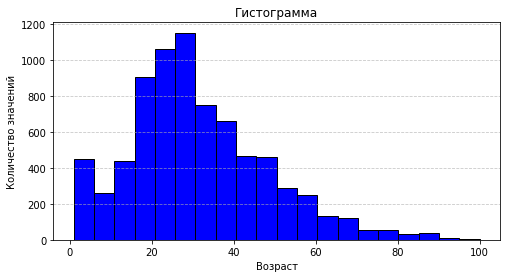

In [6]:
data['real_age'].plot(kind='hist', bins=20, color='blue', edgecolor='black', figsize=(8,4)) 

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.title('Гистограмма')
plt.ylabel('Количество значений')
plt.xlabel('Возраст')

plt.show()

Распределение имеет выраженный пик в среднем диапазоне возрастов (20 - 30 лет). Слева и справа от пика наблюдается постепенное уменьшение частоты,, что указывает на меньшее количество людей старшего возраста. Левый хвост также постепенно снижается, но сохраняет более равномерное распределение на младших возрастах. Общее распределение близко к нормальному, но с асимметрией в сторону более высоких возрастов.

Размер батча изображений: (32, 224, 224, 3)
Размер батча меток возраста: (32,)
Возрасты в батче: [13 36 21 22 45 45 52 10 41 21 19 54 43  1 16 19 28 62 25 29 24 16 10 54
 23 30 30 50 72 13 70 30]


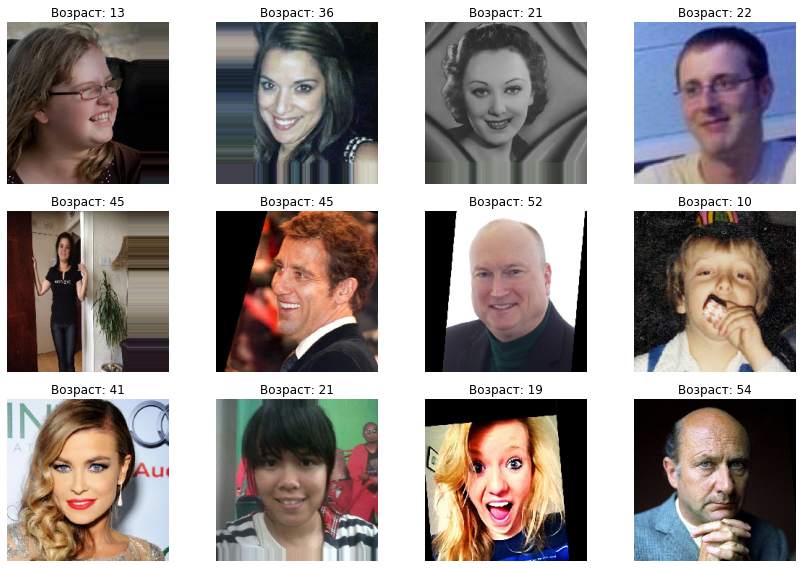

In [7]:

images, ages = train_generator.next()


print(f"Размер батча изображений: {images.shape}")
print(f"Размер батча меток возраста: {ages.shape}")
print(f"Возрасты в батче: {ages}")

plt.figure(figsize=(12, 8))
for i in range(min(12, images.shape[0])):  
    plt.subplot(3, 4, i + 1)
    plt.imshow(images[i])
    plt.title(f"Возраст: {ages[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

**Промежуточный вывод:**

- **Анализ распределения возрастов:**
  - Гистограмма демонстрирует пик в диапазоне 20–30 лет с длинным правым хвостом, простирающимся до 100 лет, что близко к нормальному распределению.
  - Аномальных значений не выявлено, что обеспечивает чистоту данных для анализа.

- **Анализ изображений:**
  - Размер батча: 32 изображения (224x224x3), метки возраста — 32 значения.
  - Наблюдается разнообразие: черно-белые и цветные фото, повороты с черными рамками, головные уборы, очки и предметы, частично закрывающие лицо.

- **Влияние на обучение модели (без дополнительной предобработки):**
  - **Несбалансированность возрастов:** Преобладание данных в диапазоне 20–30 лет и меньшее количество примеров для экстремальных возрастов (младше 10 и старше 60 лет) может привести к смещению модели в сторону более представленных групп. Это увеличит ошибку предсказаний для редких возрастных категорий, особенно на краях распределения.
  - **Разнообразие условий съемки:** Влияние поворотов, черных рамок и нестандартных ракурсов усложнит извлечение стабильных признаков. Модель может хуже обобщать на изображения с сильными искажениями или нестандартным освещением.
  - **Наличие шумов и аксессуаров:** Головные уборы, очки и объекты перед лицом, оставленные без обработки, могут маскировать ключевые черты лица, снижая точность предсказаний. Модель рискует переобучиться на шумные паттерны вместо значимых признаков возраста.
  - **Общее воздействие:** Без предобработки модель столкнется с повышенным риском переобучения на доминирующие классы и утратой точности для сложных случаев. 

<a id="section3"></a>
## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

def load_train(path):
    
    csv_path = os.path.join(path, 'labels.csv')
    df = pd.read_csv(csv_path)
    
    img_dir = os.path.join(path, 'final_files')
    
    datagen = ImageDataGenerator(
        rescale=1./255, 
        validation_split=0.2
    )

    train_generator = datagen.flow_from_dataframe(
        dataframe=df,
        directory=img_dir, 
        x_col='file_name',  
        y_col='real_age',  
        target_size=(224, 224),  
        batch_size=32,
        class_mode='raw',  
        subset='training',
        seed=12345
    )
    
    return train_generator

def load_test(path):
    
    csv_path = os.path.join(path, 'labels.csv')
    df = pd.read_csv(csv_path)
    
    img_dir = os.path.join(path, 'final_files')
    
    datagen = ImageDataGenerator(
        rescale=1./255, 
        validation_split=0.2
    )

    test_generator = datagen.flow_from_dataframe(
        dataframe=df,
        directory=img_dir, 
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345
    )
    
    return test_generator  

def create_model(input_shape=(224, 224, 3)):
    backbone = ResNet50(
        input_shape=(224, 224, 3),
        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
        include_top=False
    )
    
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))  
    
    model.compile(
        loss='mean_squared_error',  
        optimizer='adam',
        metrics=['mae']  
        
    )
    
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=20, steps_per_epoch=None, validation_steps=None):
    model.fit(
        train_data,
        validation_data=test_data,
        epochs=epochs,
        batch_size=batch_size,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2,
        shuffle=True
    )
    
    return model

```

```
Found 6073 validated image filenames.
Found 1518 validated image filenames.

Train for 190 steps, validate for 48 steps
Epoch 1/20
190/190 - 50s - loss: 220.9670 - mae: 11.3005 - val_loss: 494.4998 - val_mae: 17.0329
Epoch 2/20
190/190 - 42s - loss: 142.8277 - mae: 9.1662 - val_loss: 692.5291 - val_mae: 21.1954
Epoch 3/20
190/190 - 42s - loss: 106.7283 - mae: 7.8816 - val_loss: 280.3480 - val_mae: 13.2036
Epoch 4/20
190/190 - 42s - loss: 84.3737 - mae: 7.0354 - val_loss: 601.2872 - val_mae: 19.4198
Epoch 5/20
190/190 - 43s - loss: 66.5891 - mae: 6.2601 - val_loss: 430.2558 - val_mae: 17.6021
Epoch 6/20
190/190 - 42s - loss: 47.0676 - mae: 5.2964 - val_loss: 113.3300 - val_mae: 8.0701
Epoch 7/20
190/190 - 43s - loss: 34.1333 - mae: 4.5153 - val_loss: 107.4922 - val_mae: 7.7640
Epoch 8/20
190/190 - 42s - loss: 24.3295 - mae: 3.8296 - val_loss: 141.9956 - val_mae: 9.0101
Epoch 9/20
190/190 - 42s - loss: 18.5430 - mae: 3.3617 - val_loss: 106.3182 - val_mae: 7.8432
Epoch 10/20
190/190 - 43s - loss: 15.9272 - mae: 3.0872 - val_loss: 94.1795 - val_mae: 7.3482
Epoch 11/20
190/190 - 42s - loss: 13.6555 - mae: 2.8502 - val_loss: 132.3399 - val_mae: 8.4592
Epoch 12/20
190/190 - 39s - loss: 11.4522 - mae: 2.6113 - val_loss: 92.5425 - val_mae: 7.3184
Epoch 13/20
190/190 - 40s - loss: 10.9268 - mae: 2.5509 - val_loss: 109.5145 - val_mae: 8.1500
Epoch 14/20
190/190 - 41s - loss: 10.7316 - mae: 2.5012 - val_loss: 95.5424 - val_mae: 7.5317
Epoch 15/20
190/190 - 40s - loss: 10.1616 - mae: 2.4304 - val_loss: 102.0791 - val_mae: 7.6173
Epoch 16/20
190/190 - 38s - loss: 9.3929 - mae: 2.3432 - val_loss: 86.9406 - val_mae: 7.2207
Epoch 17/20
190/190 - 39s - loss: 9.6908 - mae: 2.3848 - val_loss: 90.0211 - val_mae: 7.3256
Epoch 18/20
190/190 - 38s - loss: 10.8754 - mae: 2.5331 - val_loss: 95.0995 - val_mae: 7.6782
Epoch 19/20
190/190 - 40s - loss: 11.2102 - mae: 2.5840 - val_loss: 120.5670 - val_mae: 8.0555
Epoch 20/20
190/190 - 40s - loss: 10.3666 - mae: 2.4780 - val_loss: 99.6312 - val_mae: 7.5542
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
48/48 - 8s - loss: 99.6312 - mae: 7.5542


```

**Промежуточный вывод:**

- **Подготовка данных:**
  - Функции `load_train` и `load_test` успешно загрузили данные из `labels.csv`, создав генераторы для обучающей (6073 изображения) и валидационной (1518 изображений) выборок с нормализацией (rescale=1./255) и размером 224x224.
  - Использован фиксированный seed=12345 для воспроизводимости.

- **Архитектура модели:**
  - Модель построена на основе ResNet50 с предобученными весами, дополненной слоями GlobalAveragePooling2D и Dense (1, ReLU).
  - Оптимизатор: Adam, функция потерь: MSE, метрика: MAE.

- **Обучение модели:**
  - Пройдено 20 эпох с 190 шагами на тренировке и 48 на валидации.
  - Начальное MAE на валидации: 17.03, финальное: 7.55



<a id="section4"></a>
## Итоговый вывод

**Итоговый вывод:**

- **Общие результаты работы:**
  - Разработана модель для определения возраста по фотографиям для сети «Хлеб-Соль».
  - Данные подготовлены: 6073 изображения для обучения, 1518 для валидации, размер 224x224, нормализация выполнена.

- **Результаты модели:**
  - Архитектура: ResNet50 с добавлением GlobalAveragePooling2D и Dense (ReLU).
  - Обучение: 20 эпох, оптимизатор Adam, метрика MAE.
  - Итоговые метрики: тренировочное MAE — 2.48, валидационное MAE — 7.55.
  - Нестабильность: val_loss варьируется от 86.94 до 692.53, val_mae — от 7.22 до 21.20, указывая на ограниченную обобщающую способность.

- **Выявленные проблемы из исследовательского анализа:**
  - **Несбалансированность данных:** Пик распределения возрастов в диапазоне 20–30 лет, недостаток данных для возрастов <10 и >60 лет.
  - **Условия съемки:** Наличие черно-белых фото, поворотов с черными рамками, головных уборов, очков и объектов перед лицом.
  - **Отсутствие предобработки:** Усилило влияние шумов и вариаций, снизив точность предсказаний.

- **Рекомендации:**
  - Собрать новые данные после внедрения модели в работу. Например исходя из фотографии на кассе и возраста указаного при регистрации скидочной карты. Чтобы модель уже училась на реалистичных данных.
  - Добавть больше фотографий подрсотков и молодежи 14-25 лет для увелечения эффиктивности контроля продаж алкоголя.
  - Обеспечить разнообразие освещения для повышения устойчивости модели.
  - Собрать сбалансированный набор для улучшения точности и надежности.

- **Итог:**
  - Модель пригодна для базового применения, но требует доработки. Улучшение данных повысят ее эффективность для анализа покупок и контроля продаж алкоголя.